<a href="https://colab.research.google.com/github/MatteoLai/dcgan-xray-generation-tutorial/blob/main/Tutorial_GAN_training-solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative models for medical imaging - training a DCGAN

In this hands-on tutorial, we will explore how generative models can be applied to medical imaging. Specifically, we will focus on generating synthetic X-ray images of hands using a Deep Convolutional GAN (DCGAN).

Tutorial structure:
1. Data Loading and Visualization
2. Define the DCGAN architecture
3. Train a DCGAN


In [ ]:
!pip install pytorch-lightning==2.5.1.post0
!pip install numpy==1.26.4
!pip install monai==1.4.0

Let's import necessary libraries:

- **PyTorch & PyTorch Lightning**: For defining and training neural networks, including GANs.
- **MONAI**: A specialized framework for medical imaging, used here to access the MedNIST dataset and preprocessing utilities.
- **Matplotlib & PIL**: For image visualization and manipulation.
- **NumPy & Pandas**: For numerical operations and data organization.
- **Other utilities**: Including tools for timing, temporary file management, and reproducibility.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import tempfile
import numpy as np
import random
import time
import math
import os
import PIL
import pandas as pd

from monai.apps import MedNISTDataset
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from monai import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

To ensure consistent results across runs, we fix the random seed and configure deterministic behavior. This is particularly important when training neural networks, where randomness in weight initialization, data loading, and GPU computations can lead to non-reproducible outcomes.

In [ ]:
random_seed = 42

os.environ['PYTHONHASHSEED'] = str(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(random_seed)
set_determinism(random_seed)

Define some useful parameters

In [ ]:
BATCH_SIZE=128
DATA_DIR = './data'
os.makedirs(DATA_DIR, exist_ok=True)

AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

## 1. Data loading and visualization

In this tutorial, we will use the **MedNIST dataset**, which is provided by the [MONAI framework](https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). This dataset includes six classes of medical imaging modalities:  AbdomenCT, BreastMRI, ChestCT, CXR, Hand, HeadCT.

To simplify the task of evaluating the realism of generated images, we will focus on the **"Hand"** class. This subset contains grayscale X-ray images of hands. Unlike other medical modalities that may require expert clinical interpretation, hand X-rays can be more intuitively assessed visually — making them well-suited for evaluating the perceptual quality of synthetic images, even by non-specialists.

The dataset is pre-split into three subsets:
- **Training set**: 7,999 images
- **Validation set**: 1,005 images
- **Test set**: 996 images

We will load the data using MONAI utilities and visualize a few sample images to understand the structure and quality of the input data before training our generative models.


### Load the MedNIST Dataset (Hand Class Only)

We begin by downloading and loading the MedNIST dataset using MONAI's built-in `MedNISTDataset` utility.
Since we are only interested in X-ray images of hands, we filter the dataset to include only samples from the **"Hand"** class.
Each sample is stored as a dictionary containing an `"image"` path and its corresponding `"label"`, which allows for label-based evaluations in future experiments.


In [ ]:
train_data = MedNISTDataset(root_dir=DATA_DIR, section="training", download=True, progress=True, seed=0) # section = ["training", "validation", "test"]
train_datalist = [
                {"image": item["image"], "label": item["label"]}
                for item in train_data.data if item["class_name"] == "Hand"
            ]

### Define Preprocessing Transforms and Create DataLoader

We define a preprocessing pipeline using MONAI transforms:

- `LoadImaged`: Loads the image from disk.
- `EnsureChannelFirstd`: Ensures images are in `[C, H, W]` format.
- `ScaleIntensityRanged`: Normalizes pixel intensities from [0, 255] to [-1, 1], which is standard for GAN training.
- `Rotate90d`: Rotates the image 270° (3 × 90°) to align the hand orientation with our expected format.

The dataset is cached in memory using `CacheDataset` for faster training. Finally, we wrap the dataset in a PyTorch `DataLoader`.


In [ ]:
train_transforms = transforms.Compose(
    [
            transforms.LoadImaged(keys=["image"]),                              # Loads image files from disk into memory
            transforms.EnsureChannelFirstd(keys=["image"]),                     # Converts image shape from [H, W] or [H, W, C] to [C, H, W]
            transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0, clip=True), # Normalizes pixel intensity from [0, 255] to [-1.0, 1.0]
            transforms.Rotate90d(keys=["image"], k=3),                          # Rotate 90° clockwise
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, persistent_workers=True
)


### Inspect and Visualize Sample Images

We then visualize a small batch of images to ensure they appear correctly after preprocessing.

In [ ]:
check_data = first(train_loader)
print(f"Number of images: {len(train_datalist)}")
print(f"batch shape: {check_data['image'].shape}")
print(f"image values: [{check_data['image'].min()}, {check_data['image'].max()}]")
print(f"image dtype: {check_data['image'].dtype}")

image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

Now that we've successfully loaded, transformed, and visualized the MedNIST data manually, it's time to organize that logic into a reusable and modular structure using PyTorch Lightning's `LightningDataModule`.

`LightningDataModule` is a powerful abstraction that helps you organize all data-related steps — including downloading, preprocessing, and loading — in a clean, reusable format. This structure is especially useful when scaling up experiments or sharing code across projects.

**Your task**
Below is a skeleton for a `MedNISTDataModule` class. Your goal is to complete it by reusing the logic you've already written:

- `self.transforms`:
    Define the preprocessing pipeline (load image, normalize intensity, convert to channel-first format, rotate).

- `prepare_data(self)`:
    Implement data downloading here. This method is called only once per machine and should not assign variables or perform transformations.

- `setup(self, stage=None)`:
    Here, initialize the datasets (e.g., training, validation, and testing) and apply the transforms. This method is called once per process (e.g., on each GPU or node) and prepares the data for that specific training or evaluation phase.

In [ ]:
class MedNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64, num_workers=2, class_names=None, root_dir=None):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.class_names = class_names if class_names else ["Hand"]
        self.dims = (1, 64, 64)

        self.root_dir = root_dir or os.environ.get("MONAI_DATA_DIRECTORY", tempfile.mkdtemp())

        self.transforms = transforms.Compose([
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0, clip=True),
            transforms.Rotate90d(keys=["image"], k=3),

        ])

    def prepare_data(self):
        """
        Download the MedNIST dataset (if not already available).
        This runs only once per machine.
        """
        if not os.path.exists(os.path.join(self.root_dir, "MedNIST")):
            MedNISTDataset(root_dir=self.root_dir, section="training", download=True)
            #MedNISTDataset(root_dir=self.root_dir, section="validation", download=True)
            #MedNISTDataset(root_dir=self.root_dir, section="test", download=True)

    def setup(self, stage=None):
        """
        Set up datasets for different stages: fit (train/val) or test.
        """
        if stage == "fit" or stage is None:
            train_data = MedNISTDataset(root_dir=self.root_dir, section="training", download=False, seed=0)
            train_datalist = [
                {"image": item["image"], "label": item["label"]}
                for item in train_data.data if item["class_name"] in self.class_names
            ]
            self.train_ds = CacheDataset(data=train_datalist, transform=self.transforms, num_workers=self.num_workers)

        #     val_data = MedNISTDataset(root_dir=self.root_dir, section="validation", download=False, seed=0)
        #     val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == self.class_name]
        #     self.val_ds = CacheDataset(data=val_datalist, transform=self.transforms, num_workers=self.num_workers)

        # # Assign test dataset
        # if stage == "test" or stage is None:
        #     test_data = MedNISTDataset(root_dir=self.root_dir, section="test", download=False, seed=0)
        #     test_datalist = [{"image": item["image"]} for item in test_data.data if item["class_name"] == self.class_name]
        #     self.test_ds = CacheDataset(data=test_datalist, transform=self.transforms, num_workers=self.num_workers)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds, batch_size=self.batch_size, shuffle=True,
            num_workers=self.num_workers, persistent_workers=True
        )

    def val_dataloader(self):
        pass

    def test_dataloader(self):
        pass


## 2. Train a GAN

### 2.1 Build the discriminator

The discriminator is a convolutional neural network (CNN) that takes an image as input and outputs a single score representing the probability that the image is real (i.e., from the dataset) rather than generated by the model.

Its architecture is composed of a series of downsampling blocks, each consisting of:
- a **convolutional layer** (`nn.Conv2d`) to extract local features [[documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)]
- **batch normalization** (`nn.BatchNorm2d`) to stabilize training by normalizing intermediate activations [[documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)]
- **Leaky ReLu** activation (`nn.LeakyReLU`) to introduce non-linearity [[documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)].

The final layer uses **sigmoid activation** (`nn.Sigmoid()`) to output a probability between 0 and 1  [[documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)].

#### Controlling spatial dimensions
To progressively reduce the spatial size of the image, each convolutional layer is configured with: `kernel_size=4` (K), `stride=2` (S), `padding=1` (P).

Using these parameters, the output dimension $𝑊_{out}$ for each convolutional block is calculated as:

$W_{out}=\frac{W_{in}-K+2P}{S}+1=\frac{W_{in}-4+2\cdot1}{2}+1=\frac{W_{in}}{2}$

This effectively halves the height and width at each stage. For an input image of size 64×64, the progression through the network looks like:

64 → 32 → 16 → 8 → 4 → 1.

#### Channel dimension
In addition to reducing the spatial resolution, each block doubles the number of channels (i.e., feature maps). These channels represent the learned visual patterns at increasing levels of abstraction $-$ from edges and textures in early layers to more complex structures in deeper ones.


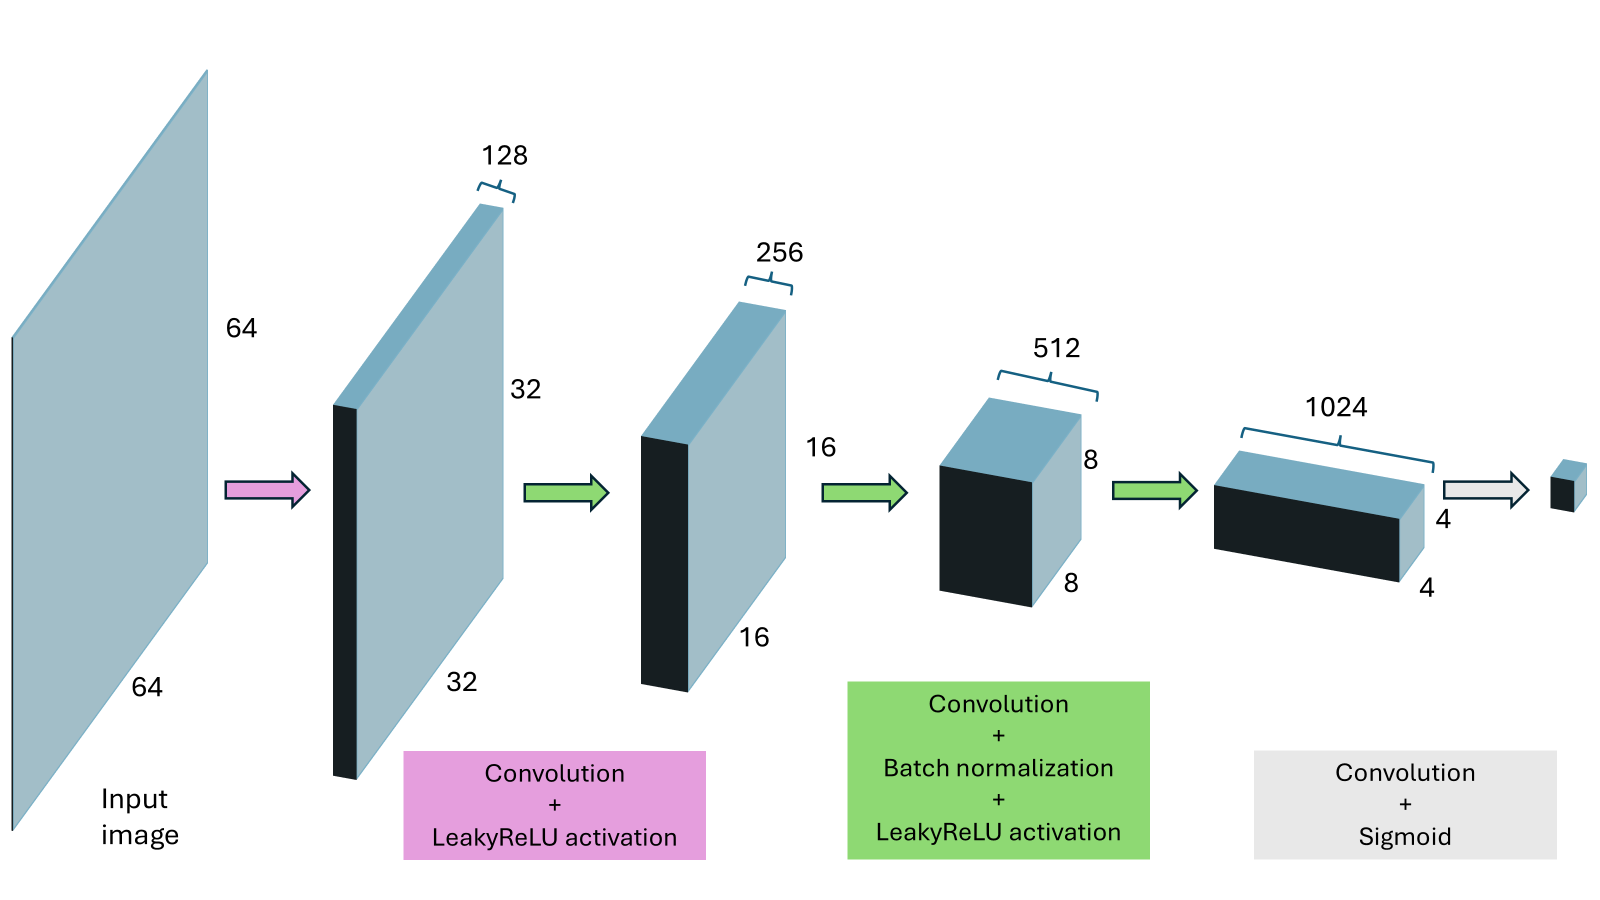

**Your task**:

Complete the code below to define the Discriminator class. Use the architecture described above.


In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]

class Discriminator(nn.Module):
    def __init__(self, nc=1):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(in_channels=nc, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``128 x 32 x 32``
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``256 x 16 x 16``
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``512 x 8 x 8``
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``1024 x 4 x 4``
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

### 2.2 Build the generator

The generator is the counterpart of the discriminator, designed to transform a vector of random noise (latent vector) into a synthetic image that mimics real data.

Its architecture mirrors that of the discriminator, but instead of using standard convolutions to downsample, it uses transposed convolutions to progressively upsample the input. Each block includes:

- a **transposed convolution** layer (`nn.ConvTranspose2d`) to increase spatial resolution [[documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)]
- a **batch normalization** (`nn.BatchNorm2d`) to stabilize training [[documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)]
- a **ReLu activation** (`nn.ReLU`) to introduce non-linearity [[documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)]

The final layer applies **Tanh** activation (`nn.Tanh()`) to return pixel values in the range [-1, 1] [[documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.Tanh.html)]

To control the spatial dimensions at each step, we use `kernel_size=4`, `stride=2`, `padding=1`.  With these parameters, the output width (and height) is calculated as:

$W_{out}=(W_{in}−1)\cdot S−2P+K = (W_{in}−1)\cdot 2−2\cdot1+4 = 2W_{in}$

This ensures the resolution doubles at every layer, ultimately converting the input latent vector into an image of size `(1, 64, 64)`.

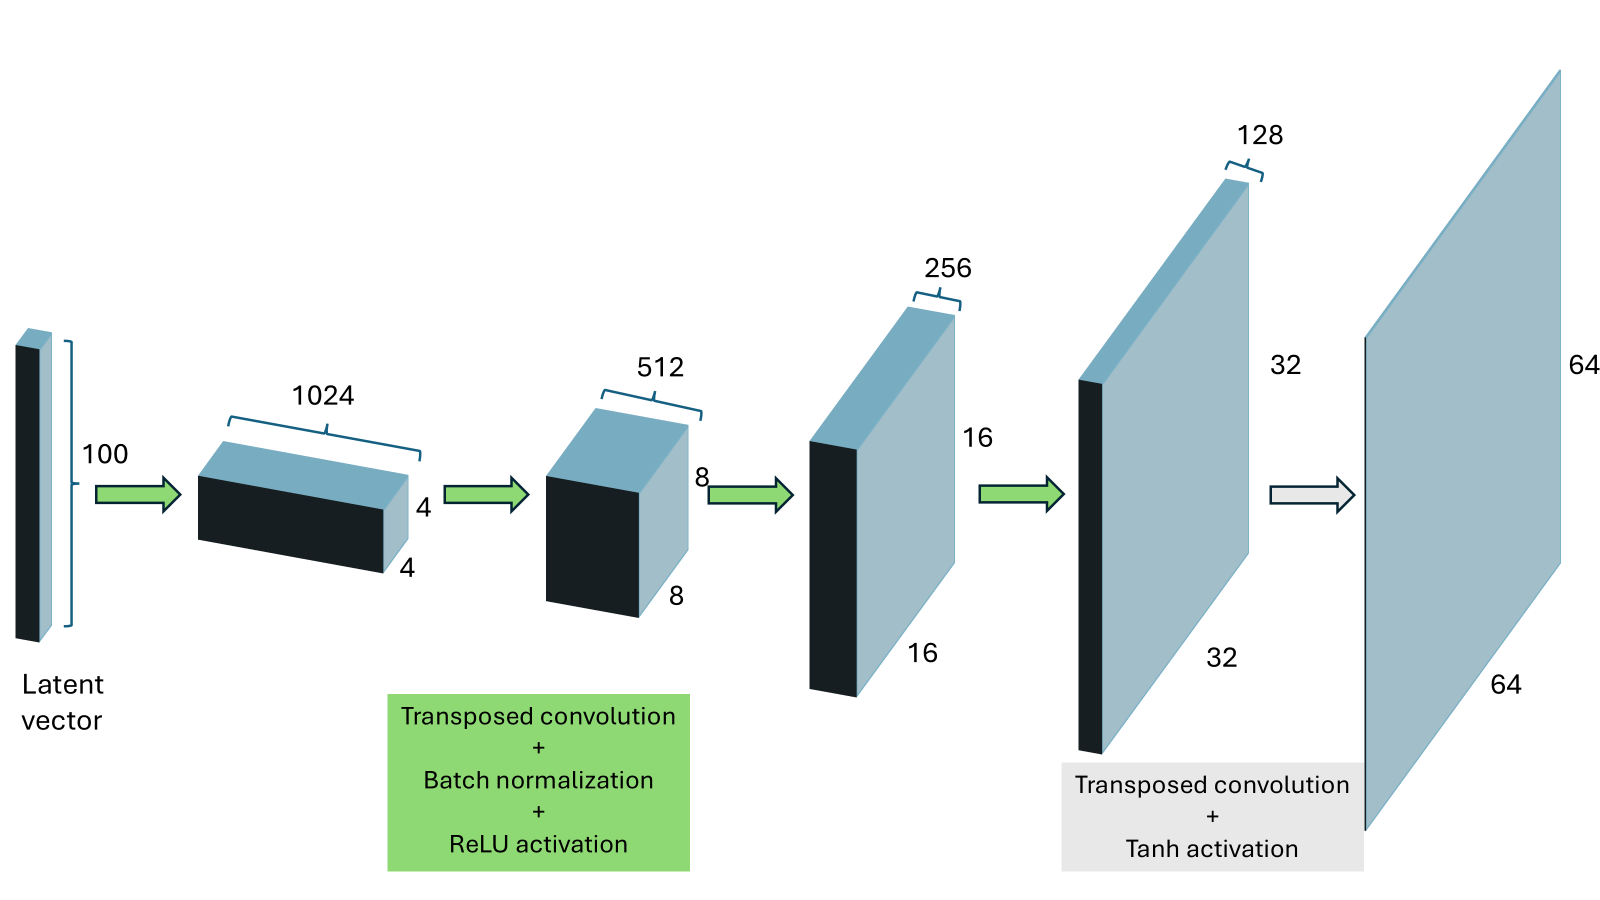

**Your task**:

Complete the code below to define the Generator class. Use the architecture described above.


In [ ]:
# Generate Synthetic Data: output like real data [1, 64, 64] and values -1, 1

class Generator(nn.Module):
    def __init__(self, latent_dim, nc=1):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=1024,
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # state size. ``1024 x 4 x 4``
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. ``512 x 8 x 8``
            nn.ConvTranspose2d( in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. ``256 x 16 x 16``
            nn.ConvTranspose2d( in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. ``128 x 32 x 32``
            nn.ConvTranspose2d( in_channels=128, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        input = input.view(input.size(0), input.size(1), 1, 1)
        return self.main(input)

### 2.3 Define the training step and loss functions

The following `GAN` class encapsulates the training logic for both the generator and discriminator using PyTorch Lightning. It inherits from `pl.LightningModule`, which provides a structured way to define training behavior, optimizers, and logging.

To train a GAN, we need two separate loss functions $-$ one for the generator and one for the discriminator $-$ because they are playing opposite roles in a two-player game:
- The **discriminator** is trained to distinguish between real images (label 1) and fake images (label 0).
- The **generator** is trained to maximize the probability that the discriminator classifies its outputs as real (i.e., label 1).

To quantify these objectives, we use **binary cross-entropy (BCE)** (`torch.nn.functional.binary_cross_entropy()`) [[documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html)] to quantify how close the discriminator's predictions are to the target labels. This allows us to directly implement the theoretical GAN losses:

- Discriminator loss:

    $L_D = - [\log(D(x)) + \log(1 - D(G(z)))]$

    --> Implemented as: $BCE(D(x), 1) + BCE(D(G(z)), 0)$

- Generator loss:
    $L_G = -  \log D(G(z))$

    --> Implemented as: $BCE(D(G(z)), 1)$

**Your task**:

In the `training_step()` function of the `GAN` class, complete the missing parts to define the adversarial training procedure.

In [ ]:
class GAN(pl.LightningModule):
  def __init__(
    self,
    channels,
    width,
    height,
    latent_dim: int = 100,
    lr: float = 0.0002,
    b1: float = 0.5,
    b2: float = 0.999,
    batch_size: int = BATCH_SIZE,
    **kwargs,
):
    super().__init__()
    self.save_hyperparameters()
    self.automatic_optimization = False

    # networks
    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator = Discriminator()

    self.validation_z = torch.randn(8, self.hparams.latent_dim)

    self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    self.g_losses = []
    self.d_losses = []
    self.g_epoch_losses = []
    self.d_epoch_losses = []
    self._g_loss_accumulator = []
    self._d_loss_accumulator = []

  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    # y_hat: predicted label; y: actual label
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch):
    real_imgs = batch["image"]

    opt_g, opt_d = self.optimizers()

    # sample noise
    z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim, device=self.device)

    # --------------------------------------- train generator: max log(D(G(z))) ---------------------------------------
    self.toggle_optimizer(opt_g) # generator optimizer: ON

    # generate images
    fake_imgs = self(z)                    # G(z)
    y_hat = self.discriminator(fake_imgs)  # D(G(z))

    # real labels
    y = torch.ones(real_imgs.size(0), 1, device=self.device)   # y_real = 1

    # define the loss
    g_loss = self.adversarial_loss(y_hat, y)

    # perform optimization steps for generator
    self.manual_backward(g_loss)
    opt_g.step()
    opt_g.zero_grad()
    self.untoggle_optimizer(opt_g) # generator optimizer: OFF


    # ------------------------------ train discriminator: max log(D(x)) + log(1 - D(G(z))) ------------------------------
    self.toggle_optimizer(opt_d) # discriminator optimizer: ON

    # assess how well can it label as real: log(D(x))
    y_hat_real = self.discriminator(real_imgs)
    y_real = torch.ones(real_imgs.size(0), 1, device=self.device) # y_real = 1

    real_loss = self.adversarial_loss(y_hat_real, y_real)

    # assess how well can it label as fake: log(1 - D(G(z)))
    y_hat_fake = self.discriminator(self(z).detach())  # .detach() prevent gradients from flowing back into the generator during the discriminator update

    y_fake = torch.zeros(real_imgs.size(0), 1, device=self.device) # y_fake = 0

    fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

    # total loss
    d_loss = (real_loss + fake_loss)

    # perform optimization steps for discriminator
    self.manual_backward(d_loss)
    opt_d.step()
    opt_d.zero_grad()
    self.untoggle_optimizer(opt_d) # discriminator optimizer: OFF

    self._g_loss_accumulator.append(g_loss.item())
    self._d_loss_accumulator.append(d_loss.item())

    # log loss
    log_dict = {'g_loss': g_loss, 'd_loss': d_loss}
    return {'loss': d_loss + g_loss, 'log': log_dict}

  def configure_optimizers(self):
      lr = self.hparams.lr
      b1 = self.hparams.b1
      b2 = self.hparams.b2

      opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
      opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
      return [opt_g, opt_d], []  # second output for scheduler

  def plot_imgs(self, real_imgs):
    z = self.validation_z.type_as(self.generator.main[0].weight)
    sample_imgs = self(z).detach().cpu()

    real_imgs = real_imgs[:4].cpu()

    fig = plt.figure(figsize=(8, 4))
    for i in range(4):
        # Plot real images
        plt.subplot(2, 4, i + 1)
        plt.axis('off')
        plt.title("Real")
        plt.imshow(real_imgs[i, 0], cmap='gray', interpolation='none')

        # Plot generated images
        plt.subplot(2, 4, i + 5)
        plt.axis('off')
        plt.title("Synthetic")
        plt.imshow(sample_imgs[i, 0], cmap='gray', interpolation='none')
    plt.show()

  def plot_losses(self):
      fig, ax = plt.subplots()
      ax.plot(self.g_losses, label="Generator Loss")
      ax.plot(self.d_losses, label="Discriminator Loss")
      ax.set_xlabel("Epochs")
      ax.set_ylabel("Loss")
      ax.set_title("GAN Training Losses")
      ax.legend()
      plt.tight_layout()
      plt.savefig("losses.png")
      plt.close()

  def on_train_epoch_end(self):
    avg_g_loss = np.mean(self._g_loss_accumulator)
    avg_d_loss = np.mean(self._d_loss_accumulator)

    self.g_losses.append(avg_g_loss)
    self.d_losses.append(avg_d_loss)

    self._g_loss_accumulator.clear()
    self._d_loss_accumulator.clear()

    print(f"[Epoch {self.current_epoch}] | Generator Loss: {self.g_losses[-1]} | Discriminator Loss: {self.d_losses[-1]}")
    # Print image samples
    real_batch = next(iter(self.trainer.datamodule.train_dataloader()))
    real_imgs = real_batch["image"]
    self.plot_imgs(real_imgs)
    # Print generator and discriminator losses
    self.plot_losses()

Now we need to instantiate the data and model. We use `MedNISTDataModule` to handle data loading and preprocessing, and then create the `GAN` model.

In [ ]:
# Create data module
dm = MedNISTDataModule(batch_size=BATCH_SIZE, root_dir=DATA_DIR)
model = GAN(*dm.dims)

Next, we define the PyTorch Lightning `Trainer`, which manages the training loop. We set it to run for 100 epochs and include a `ModelCheckpoint` callback to save the latest model. Finally, we start training by calling `trainer.fit()` with our GAN model and data module.

In [ ]:
# trainer = pl.Trainer(max_epochs=100)#, gpus=AVAIL_GPUS)
trainer = pl.Trainer(max_epochs=100, callbacks=[ModelCheckpoint(dirpath='.', filename='last', save_last=True)])

start_time = time.time()
trainer.fit(model, dm)

time_end = time.time() - start_time
print(f'\n Training time: {time_end} s', flush=True)
m, h = math.modf(time_end/3600)
print(' --> {} hours and {} minutes.'.format(int(h), int(m*60)), flush=True)